In [108]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import copy

> Für die vereinfachte Anzeige von Bildern definieren wir die Funktion imshow(), die als Parameter ein Grauwertbild oder ein BGR-Farbbild erwartet und dieses anzeigt. Somit muss nicht jedes mal manuell die cmap (bei Grauwertbildern) gesetzt oder die Farbraumkonvertierung (von BGR-OpenCV-Bildern zu RGB-Bildern für die Anzeige mit MatPlotLib) durchgeführt werden. 

In [109]:
def imshow(img):
    shape=img.shape
    #plt.figure(figsize = (10,10))
    if(len(shape)==2):
        plt.imshow(img,cmap='gray', vmin=0, vmax=2**8)
    else:
        plt.imshow(img[:,:,::-1])
    plt.axis(False)
    plt.show()        

In [110]:
color = "undefined"
amount = -1
fill = "undefined"
form = "undefined"

In [134]:
# Wenn das gesamte Dokument ausgeführt wurde, kann diese Zelle 
# nochmal ausgeführt werden, um auf die Variablen der Klassifizierung zuzugreifen.
(color, amount, fill, form)

('b', 3, 's', 't')

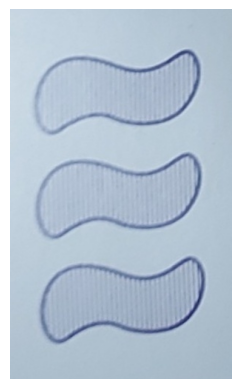

In [112]:
# Bild einlesen
src_file = 'set/cards/card79_b_3_s_t.jpg'
image = cv2.imread(src_file)
imshow(image)

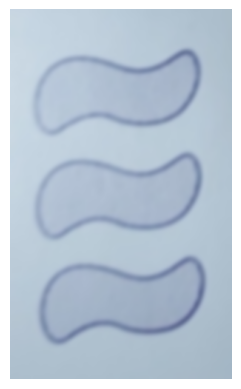

In [113]:
# Bildglättung mit Gauss

blurred_image = cv2.GaussianBlur(image, (25,25), 3)
imshow(blurred_image)

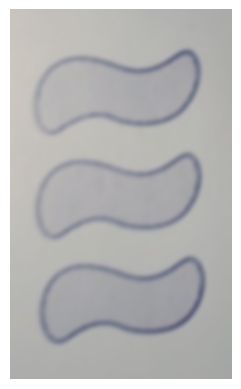

In [114]:
# Weißabgleich

wb = cv2.xphoto.createGrayworldWB()
balanced_image = wb.balanceWhite(blurred_image)
imshow(balanced_image)

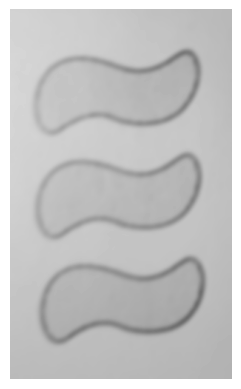

In [115]:
# Bild umwandeln in schwarz-weiß

gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
imshow(gray_image)

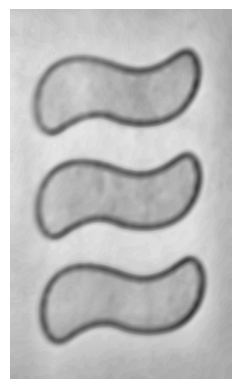

In [116]:
# Equalize
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
clahe_image = clahe.apply(gray_image)
imshow(clahe_image)

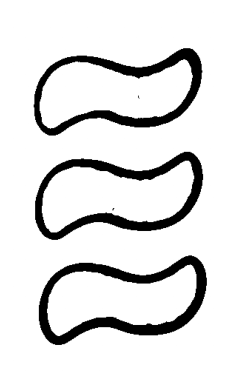

In [117]:
# Binarisieren

ret, binarized_image = cv2.threshold(clahe_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(binarized_image)

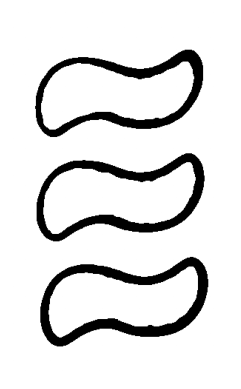

In [118]:
# Bild bereinigen
# Perform morphological operations to clean up the binary image
kernel = np.ones((4, 4), np.uint8)
cleaned_image = cv2.morphologyEx(binarized_image, cv2.MORPH_CLOSE, kernel)
cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_OPEN, kernel)

imshow(cleaned_image)

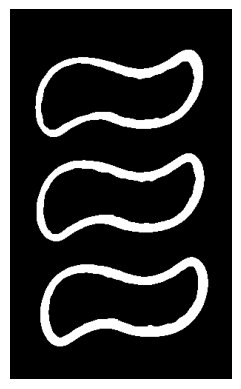

In [119]:
# Bild invertieren
inverted_image = cv2.bitwise_not(cleaned_image)
imshow(inverted_image)

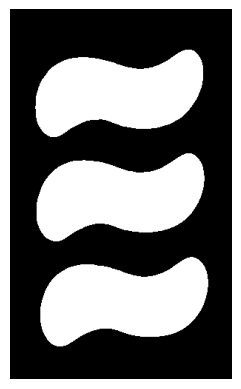

In [120]:
# Find contours in the image
contours, hierarchy = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a black image of the same size as the input image
filled_image = np.zeros_like(inverted_image)

filtered_contours = []

for contour in contours:
    # Calculate the area of the current contour
    area = cv2.contourArea(contour)

    if (area > (60 * 60)):
        cv2.drawContours(filled_image, [contour], 0, 255, cv2.FILLED)
        filtered_contours.append(contour)

imshow(filled_image)

> Aus diesem Bild kann man nun ganz sicher sehr viele wichtige Informationen ableiten:  
> - Anzahl an Symbolen  
> - Form  
> - an welchen Pixeln sich die Symbole befinden (Diese Information ist sinnfoll, um die Füllung zu bestimmen)  
> 
> Um die Form zu bestimmen, müssen die Symbole jedoch vorher ausgeschnitten werden

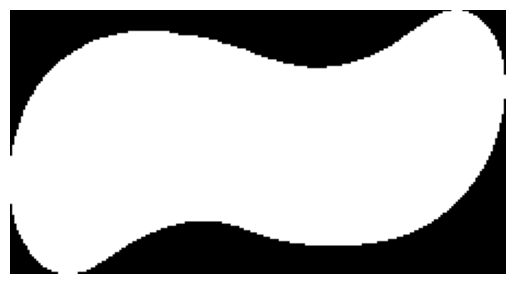

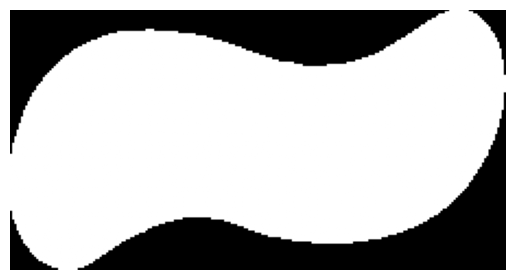

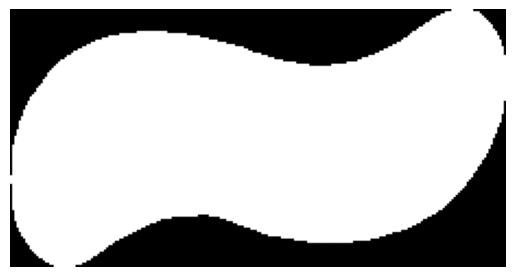

In [121]:
# Extract and store the objects
symbols = []
i = 0
for contour in filtered_contours:
    x, y, w, h = cv2.boundingRect(contour)
    symbol = filled_image[y:y+h, x:x+w]
    symbols.append(symbol)
    imshow(symbol)

# Hilfsvariablen

In [122]:
MAX_PIXEL_VALUE = 255

index_center_column = filled_image.shape[1] // 2
index_center_column


150

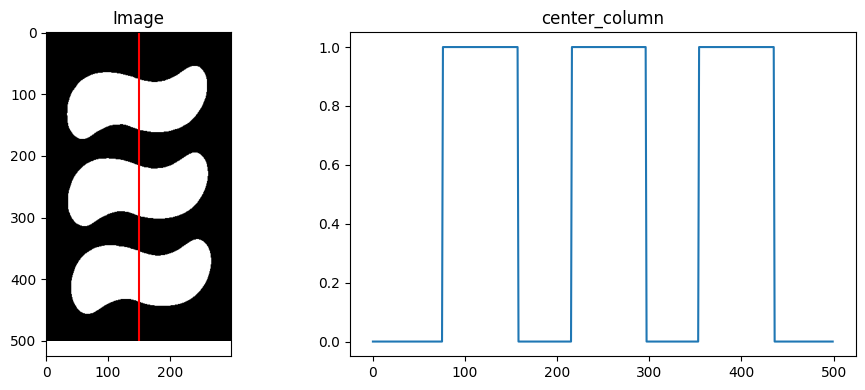

In [123]:
center_column_filled = filled_image[:, index_center_column]
center_column_filled = center_column_filled / MAX_PIXEL_VALUE


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the image in the first subplot
ax1.imshow(filled_image, cmap='gray')
ax1.vlines(index_center_column, 0, len(center_column_filled), "red")
ax1.set_title('Image')

# Plot the array in the second subplot
ax2.plot(center_column_filled)
ax2.set_title('center_column')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

> Besonders wichtig sind die "center_columns". Diese sind einfach nur eine vertikale Pixelreihe aus der Mitte des Bildes. Denn um alle Merkmale zu bestimmen reicht es aus, nur eine Spalte aus dem Bild zu betrachten.

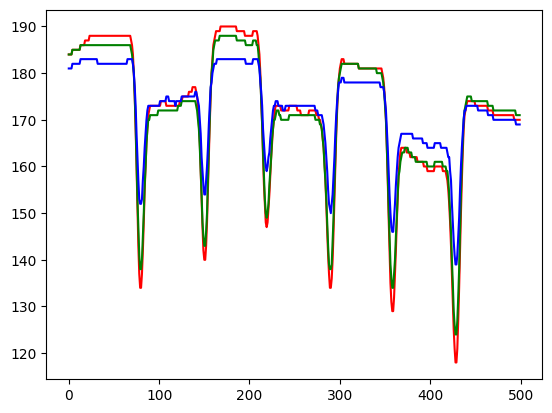

In [124]:
center_column_red = balanced_image[:,:,2][:, index_center_column]
center_column_green = balanced_image[:,:,1][:, index_center_column]
center_column_blue = balanced_image[:,:,0][:, index_center_column]

plt.plot(center_column_red, "red")
plt.plot(center_column_green, "green")
plt.plot(center_column_blue, "blue")

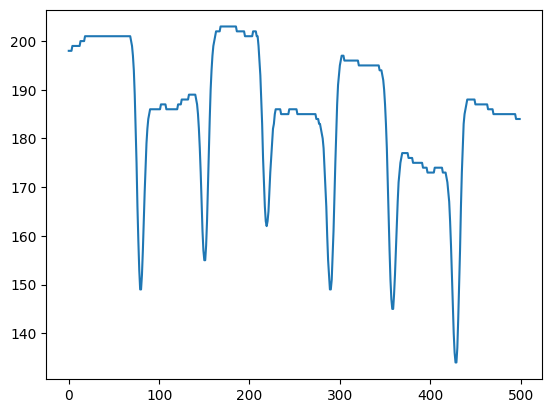

In [125]:
center_column_gray = gray_image[:, index_center_column]
plt.plot(center_column_gray)
plt.show()

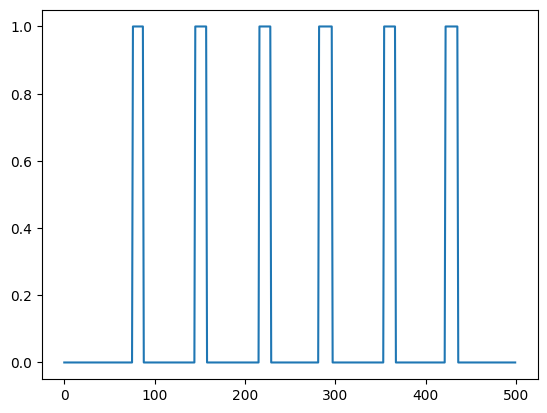

In [126]:
center_column_inverted = inverted_image[:, index_center_column]
center_column_inverted = center_column_inverted / MAX_PIXEL_VALUE
plt.plot(center_column_inverted)
plt.show()

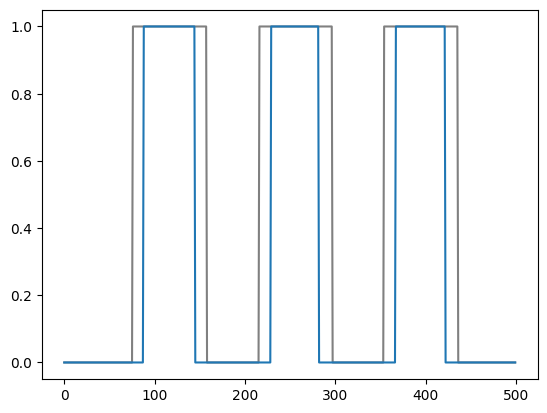

In [127]:
center_column_inside = center_column_filled - center_column_inverted
plt.plot(center_column_filled, "gray")
plt.plot(center_column_inside)
plt.show()

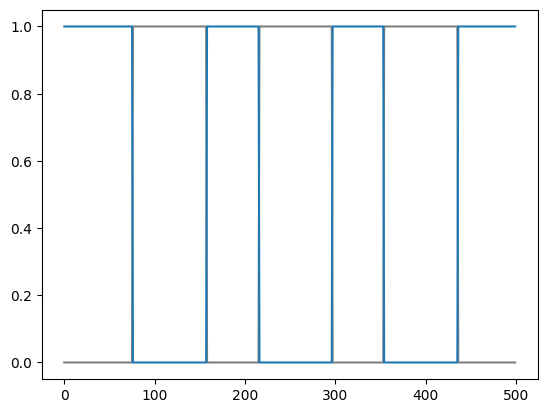

In [128]:
center_column_outside = np.ones(len(center_column_filled)) - center_column_filled
plt.plot(center_column_filled, "gray")
plt.plot(center_column_outside)
plt.show()

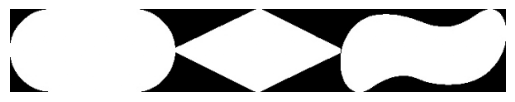

In [129]:
# Samples zum abgleichen beim erkennen der Form+
oval_sample = cv2.imread("sample/oval.jpg", cv2.IMREAD_GRAYSCALE)
diamond_sample = cv2.imread("sample/diamond.jpg", cv2.IMREAD_GRAYSCALE)
wave_sample = cv2.imread("sample/wave.jpg", cv2.IMREAD_GRAYSCALE)
imshow(np.hstack((oval_sample, diamond_sample, wave_sample)))

SAMPLE_HEIGHT = oval_sample.shape[0]
SAMPLE_WIDTH = oval_sample.shape[1]

# Detect Color

'b'

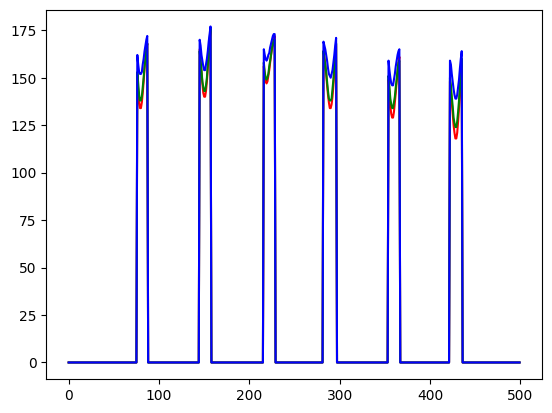

In [130]:
blue_sum = sum(center_column_blue * center_column_inverted)
green_sum = sum(center_column_green * center_column_inverted)
red_sum = sum(center_column_red * center_column_inverted)

plt.plot(center_column_red * center_column_inverted, "red")
plt.plot(center_column_green * center_column_inverted, "green")
plt.plot(center_column_blue * center_column_inverted, "blue")

color = "undefined"
if (blue_sum >= green_sum and blue_sum >= red_sum):
    color = "b"
elif (green_sum >= blue_sum and green_sum >= red_sum):
    color = "g"
else:
    color = "r"
color

# Detect Amount

In [131]:
amount = 0
for i in range(len(center_column_filled)):
    if (center_column_filled[i] - center_column_filled[i - 1] == 1):
        amount += 1
amount

3

# Detect Fill

In [132]:
if (sum(center_column_inside) == 0):
    fill = "f"
else:
    outer_pixels = 0
    inner_pixels = 0
    outer_pixel_sum = 0
    inner_pixel_sum = 0
    for i in range(len(center_column_inside)):
        if (center_column_outside[i] == 1):
            outer_pixels += 1
            outer_pixel_sum += center_column_gray[i]
        elif (center_column_inside[i] == 1):
            inner_pixels += 1
            inner_pixel_sum += center_column_gray[i]
    avg_outer_pixel_value = outer_pixel_sum / outer_pixels
    avg_inner_pixel_value = inner_pixel_sum / inner_pixels
    print(f"avg_outer_pixel_value: {avg_outer_pixel_value}")
    print(f"avg_inner_pixel_value: {avg_inner_pixel_value}")
    if (avg_outer_pixel_value - avg_inner_pixel_value < 10):
        fill = "l"
    else:
        fill = "s"
fill

avg_outer_pixel_value: 195.04705882352943
avg_inner_pixel_value: 182.02424242424243


's'

# Detect Form

In [133]:
def form_deviation(symbol, sample):
    deviation = 0
    for x in range(SAMPLE_WIDTH):
        for y in range(SAMPLE_HEIGHT):
            if (sample[y][x] != symbol[y][x]):
                deviation += 1
    return deviation

oval_deviation = 0
diamond_deviation = 0
wave_deviation = 0
for symbol in symbols:
    symbol_resized = cv2.resize(symbol, (SAMPLE_WIDTH, SAMPLE_HEIGHT))

    oval_deviation += form_deviation(symbol_resized, oval_sample)
    diamond_deviation += form_deviation(symbol_resized, diamond_sample)
    wave_deviation += form_deviation(symbol_resized, wave_sample)

print("Ähnlichkeit zu den Sample Formen (je kleiner desto ähnlicher)")
print(f"oval: {oval_deviation}")
print(f"diamond: {diamond_deviation}")
print(f"wave: {wave_deviation}")

form = "undefined"
if (oval_deviation < diamond_deviation and oval_deviation < wave_deviation):
    form = "o"
elif (diamond_deviation < oval_deviation and diamond_deviation < wave_deviation):
    form = "v"
elif (wave_deviation < oval_deviation and wave_deviation < diamond_deviation):
    form = "t"

form

Ähnlichkeit zu den Sample Formen (je kleiner desto ähnlicher)
oval: 18965
diamond: 21438
wave: 7394


't'